## MLP3 Baseline Results

Expects:

- weight.h5 files in ./weights 
- CIFAR10 data in ../data/cifar-10-batches-py/

and while the keras code needs py27, the notebooks can use py3.6 

### TODO:  

- move weights to standard place so others can download
- include python code & scripts to regenerate results from scratch if necessary
- document code precisely in paper
- test regeneration end to end with git clone


In [1]:
import numpy as np
import pickle, time
from copy import deepcopy
from shutil import copy
import import_ipynb
from tqdm import tqdm_notebook as tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import keras
from keras.callbacks import TensorBoard, EarlyStopping
from keras.optimizers import SGD
from keras.initializers import Constant
import keras.backend as K

import RMT_Util

/Users/charlesmartin14/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/charlesmartin14/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


importing notebook from RMT_Util.ipynb
3.6.5 |Anaconda custom (64-bit)| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version 1.14.2
scipy version 1.0.1
tensforflow version 1.5.0-dev20171116
keras version 2.1.5
sklearn version 0.19.1
powerlaw version 1.4.3


In [2]:
matplotlib.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [5,5]

In [3]:
BASELINE_outfile = 'results/cifar10_keras_mlp3.out'

BASELINE_final_weightfile = 'weights/model.b16.final.h5'
BASELINE_per_epoch_weightfile = "weights/model.b16.e{}.h5"
NUM_BASELINE_EPOCHS = 45

BASELINE_init_weighfile = 'weights/model.b16.e0.h5'

REGULARIZED_final_weightfile = 'weights/model.b16.wd.final.h5'
RANDOMIZED_final_weightfile = 'weights/model.b16.rand100.final.h5'

LAYER_FC1 = 2
LAYER_FC2 = 3

ENTROPY_FILE = "img/mlp3-entropies.png"
RANK_FILE = "img/mlp3-ranks.png"

INIT_SEMICIRCLE_FC1_FILE =  "img/mlp3-init-semicirle-fc1.png"
FINAL_SEMICIRCLE_FC1_FILE = "img/mlp3-final-semicirle-fc1.png"
INIT_ESD_FC1_FILE =  "img/mlp3-init-esd-fc1.png"
FINAL_ESD_FC1_FILE = "img/mlp3-final-esd-fc1.png"

INIT_SEMICIRCLE_FC2_FILE =  "img/mlp3-init-semicircle-fc2.png"
FINAL_SEMICIRCLE_FC2_FILE = "img/mlp3-final-semicircle-fc2.png"
INIT_ESD_FC2_FILE =  "img/mlp3-init-esd-fc2.png"
FINAL_ESD_FC2_FILE = "img/mlp3-final-esd-fc2.png"

INIT_SCREE_FILE =  "img/mlp3-init-scree.png"
FINAL_SCREE_FILE =  "img/mlp3-final-scree.png"

In [4]:
!ls /Users/charlesmartin14/work/DLGeneralization/MLP3/weights

model.b16.e0.h5               model.b16.wd.rand100.e51.h5
model.b16.e1.h5               model.b16.wd.rand100.e52.h5
model.b16.e10.h5              model.b16.wd.rand100.e53.h5
model.b16.e11.h5              model.b16.wd.rand100.e54.h5
model.b16.e12.h5              model.b16.wd.rand100.e55.h5
model.b16.e13.h5              model.b16.wd.rand100.e56.h5
model.b16.e14.h5              model.b16.wd.rand100.e57.h5
model.b16.e15.h5              model.b16.wd.rand100.e58.h5
model.b16.e16.h5              model.b16.wd.rand100.e59.h5
model.b16.e17.h5              model.b16.wd.rand100.e6.h5
model.b16.e18.h5              model.b16.wd.rand100.e60.h5
model.b16.e19.h5              model.b16.wd.rand100.e61.h5
model.b16.e2.h5               model.b16.wd.rand100.e62.h5
model.b16.e20.h5              model.b16.wd.rand100.e63.h5
model.b16.e21.h5              model.b16.wd.rand100.e64.h5
model.b16.e22.h5              model.b16.wd.rand100.e65.h5
model.b16.e23.h5              model.b16.wd.rand100.e66.h5
model.b16.e24.h

### Get the weights from somewhere

#### I store the MLP3 and Alexnet weights in different folders and link them over as needed

(Need to push to s3 or oher long term storage)

In [5]:
!rm weights; ln -s /Users/charlesmartin14/work/DLGeneralization/MLP3/weights .
!cd weights; ln -s model.b16.final.h5 model.b16.e44.h5
!cd weights; ls -l model.b16.e44.h5
!rm results; ln -s /Users/charlesmartin14/work/DLGeneralization/MLP3/results .
!ls results/
!ln -s /Users/charlesmartin14/work/DLGeneralization/data .

ln: model.b16.e44.h5: File exists
lrwxr-xr-x  1 charlesmartin14  staff  18 Apr 10 20:46 model.b16.e44.h5 -> model.b16.final.h5
cifar10_keras_mlp3.b2.out         cifar10_keras_mlp3.r100.out
cifar10_keras_mlp3.b2.r100.out    cifar10_keras_mlp3.r100.wd.out
cifar10_keras_mlp3.b2.r100.wd.out cifar10_keras_mlp3.wd.out
cifar10_keras_mlp3.b2.wd.out      results.out
cifar10_keras_mlp3.out
ln: ./data: File exists


## Baseline 

In [6]:
model = RMT_Util.MLP3_model()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [7]:
model.load_weights(BASELINE_final_weightfile)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1204736   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 1,735,178
Trainable params: 1,735,178
Non-trainable params: 0
_________________________________________________________________
None


#### Check baseline shapes

In [8]:
for layer in model.layers:
    weights = layer.get_weights() 
    if len(weights)>0 :
        W = weights[0]
        print(W.shape)

(2352, 512)
(512, 512)
(512, 512)
(512, 10)


## BASLINE

### Compute Entropy, Rank, and Accuracies per Epoch

Baseline has 44 epochs...we can do more if necessary


In [9]:
fc1_entropies, fc2_entropies = [], []
fc1_ranks, fc2_ranks = [], []
for epoch in tqdm(range(NUM_BASELINE_EPOCHS)):
    model.load_weights(BASELINE_per_epoch_weightfile.format(epoch))   
    fc1_entropies.append(RMT_Util.layer_entropy(model, LAYER_FC1))
    fc2_entropies.append(RMT_Util.layer_entropy(model, LAYER_FC2))
    
    fc1_ranks.append(RMT_Util.layer_soft_rank(model, LAYER_FC1))
    fc2_ranks.append(RMT_Util.layer_soft_rank(model, LAYER_FC2))

In [10]:
assert(len(fc1_entropies)==NUM_BASELINE_EPOCHS)
assert(len(fc2_entropies)==NUM_BASELINE_EPOCHS)

assert(len(fc1_ranks)==NUM_BASELINE_EPOCHS)
assert(len(fc2_ranks)==NUM_BASELINE_EPOCHS)

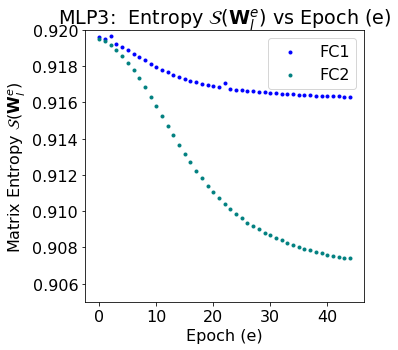

In [11]:
plt.scatter(range(0,len(fc1_entropies)), fc1_entropies, marker='.', color='blue', label='FC1')
plt.scatter(range(0,len(fc2_entropies)), fc2_entropies, marker='.', color='teal', label='FC2')
plt.ylim([0.905,0.920])
plt.title('MLP3:  Entropy $\mathcal{S}(\mathbf{W}^{e}_{l})$ vs Epoch (e)')
plt.xlabel("Epoch (e)")
plt.ylabel(r"Matrix Entropy $\mathcal{S}(\mathbf{W}^{e}_{l})$")
#plt.ylim(np.min(fc1_entropies)-0.001, np.max(fc1_entropies)+0.001)
plt.legend()

plt.savefig(ENTROPY_FILE)

#### Soft Ranks

In [12]:
fc1_ranks, fc2_ranks = [], []

for epoch in tqdm(range(NUM_BASELINE_EPOCHS)):
    model.load_weights(BASELINE_per_epoch_weightfile.format(epoch))   
    fc1_ranks.append(RMT_Util.layer_soft_rank(model, LAYER_FC1))
    fc2_ranks.append(RMT_Util.layer_soft_rank(model, LAYER_FC2))

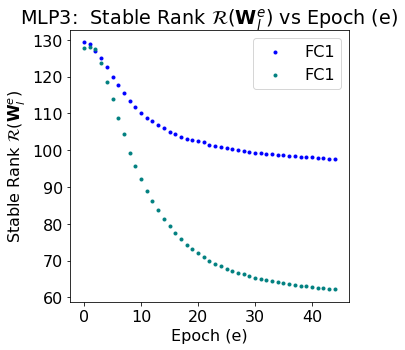

In [13]:
plt.scatter(range(0,len(fc1_ranks)), fc1_ranks, marker='.', color='blue', label='FC1')
plt.scatter(range(0,len(fc2_ranks)), fc2_ranks, marker='.', color='teal', label='FC1')
#plt.ylim([0.905,0.920])
plt.title(r'MLP3:  Stable Rank $\mathcal{R}(\mathbf{W}^{e}_{l})$ vs Epoch (e)')
plt.xlabel("Epoch (e)")
plt.ylabel(r"Stable Rank $\mathcal{R}(\mathbf{W}^{e}_{l})$")
plt.legend()

plt.savefig("img/mlp3-ranks")

#### Read Baseline Training accuracies from output file

Notice: there is no epoch=0 training accuracy

In [14]:
bsln_train_accs =  RMT_Util.read_training_accuracies(BASELINE_outfile)
assert(len(bsln_train_accs)==NUM_BASELINE_EPOCHS-1)

#### Recompute Baseline Test accuracies 

In [15]:
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [16]:
test_images, test_labels = RMT_Util.read_test_images(datadir="./data")

Loading test images...


In [17]:
bsln_test_accs = []
for epoch in tqdm(range(NUM_BASELINE_EPOCHS)):
    modelfile = BASELINE_per_epoch_weightfile.format(epoch)
    model.load_weights(modelfile)
    acc =  model.evaluate(test_images, test_labels, batch_size=256)
    bsln_test_accs.append(acc[1])

10000/10000 [==============================] - 1s 57us/step



###  MLP3 is pretty bad, and easily overtrained</font>

### We see how the phase transition corresponds with overtraining on the training data 

#### But random would be %10, so it is not totally bananas

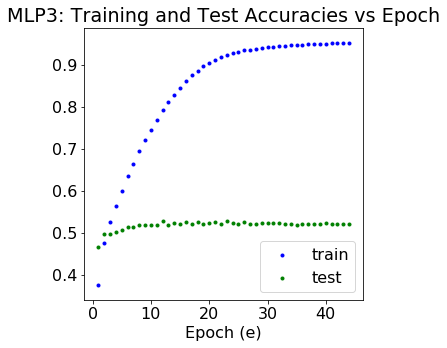

In [18]:
x = range(1,NUM_BASELINE_EPOCHS)

#plt.scatter(x, w2_entropies[1:], marker='.', color='blue')
#plt.scatter(x, w3_entropies[1:], marker='.', color='green')
plt.scatter(x, bsln_train_accs,  marker='.',color='blue', label="train" )
plt.scatter(x, bsln_test_accs[1:],  marker='.',color='green', label="test")

plt.title('MLP3: Training and Test Accuracies vs Epoch')
plt.xlabel("Epoch (e)")
plt.legend()
plt.show()

## Create 9 ESD plots, 3x3 grid

In [19]:
matplotlib.rcParams.update({'font.size': 10})
plt.rcParams['figure.figsize'] = [10,10]

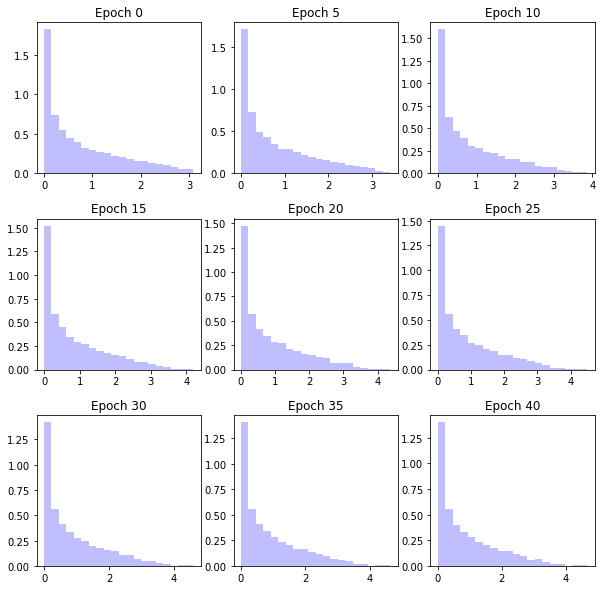

In [20]:
LAYER = 2
f, axes = plt.subplots(3,3)



for idx, epoch in enumerate(np.arange(0,NUM_BASELINE_EPOCHS,5)):
    weightfile = BASELINE_per_epoch_weightfile.format(epoch)
    eigenvalues = RMT_Util.get_eigenvalues(model, weightfile, layer=LAYER)

    iay = idx % 3
    iax = int(idx / 3)
    #print(idx, iax, iay, modelfile)
    subplot = axes[iax,iay]
    subplot.hist(eigenvalues, bins=20, alpha=0.25, color='blue', density=True);
    subplot.set_title("Epoch {}".format(epoch));

    
f.subplots_adjust(hspace=0.3)
plt.show()

#plt.savefig('img/MLP_W2_ESDs.png')

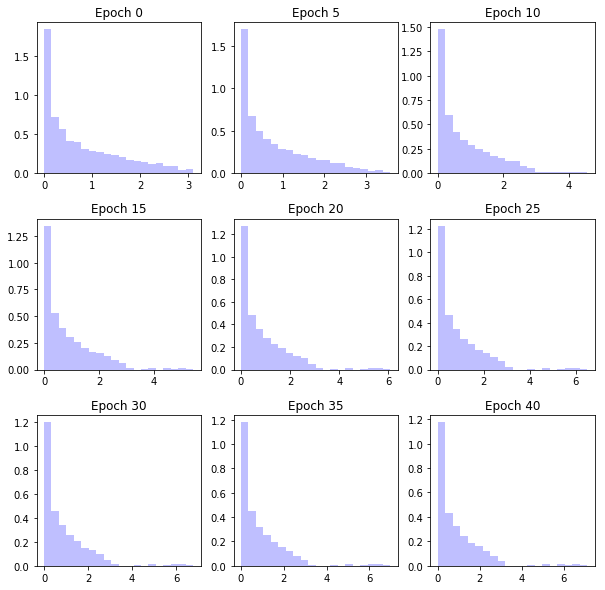

In [21]:
LAYER = 3
f, axes = plt.subplots(3,3)

for idx, epoch in enumerate(np.arange(0,NUM_BASELINE_EPOCHS,5)):
    weightfile = BASELINE_per_epoch_weightfile.format(epoch)
    eigenvalues = RMT_Util.get_eigenvalues(model, weightfile, layer=LAYER)

    iay = idx % 3
    iax = int(idx / 3)
    #print(idx, iax, iay, modelfile)
    subplot = axes[iax,iay]
    subplot.hist(eigenvalues, bins=20, alpha=0.25, color='blue', density=True);
    subplot.set_title("Epoch {}".format(epoch));

    
f.subplots_adjust(hspace=0.3)
plt.show()

#fig = plt.figure()
#fig.savefig('MLP_W2_ESDs.png')

In [22]:
matplotlib.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [5,5]

### Fit Marchenko Pastur to ESD


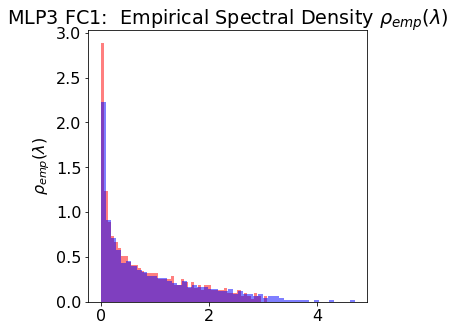

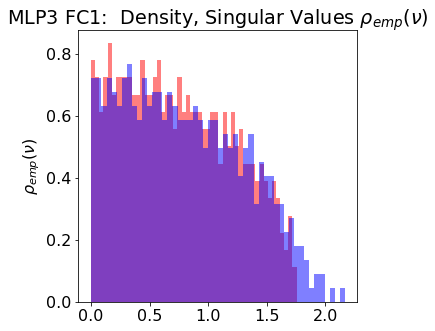

In [23]:
LAYER=LAYER_FC1
EPOCH=0
weightfile = BASELINE_per_epoch_weightfile.format(EPOCH)
eigenvalues0 = RMT_Util.get_eigenvalues(model, weightfile, layer=LAYER)
singular_values0 = np.sqrt(eigenvalues0)

weightfile = BASELINE_final_weightfile
eigenvalues = RMT_Util.get_eigenvalues(model, weightfile, layer=LAYER)
singular_values = np.sqrt(eigenvalues)

plt.hist(eigenvalues0,bins=50, density=True, color='red', alpha=0.5, label="initial")
plt.hist(eigenvalues,bins=50, density=True, color='blue', alpha=0.5, label="final")
plt.title(r"MLP3 FC1:  Empirical Spectral Density $\rho_{emp}(\lambda)$")
plt.ylabel(r"$\rho_{emp}(\lambda)$")
plt.savefig(FINAL_ESD_FC1_FILE)

plt.show()

plt.hist(singular_values0,bins=50, density=True, color='red', alpha=0.5, label="initial")
plt.hist(singular_values,bins=50, density=True, color='blue', alpha=0.5, label="final")
plt.title(r"MLP3 FC1:  Density, Singular Values $\rho_{emp}(\nu)$")
plt.ylabel(r"$\rho_{emp}(\nu)$")
plt.savefig(FINAL_SEMICIRCLE_FC1_FILE)

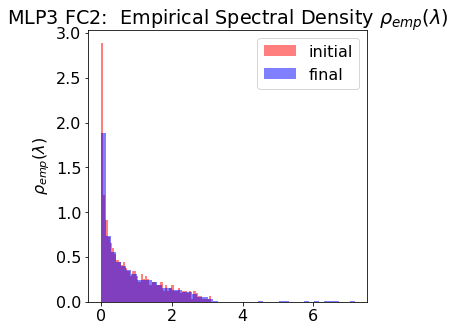

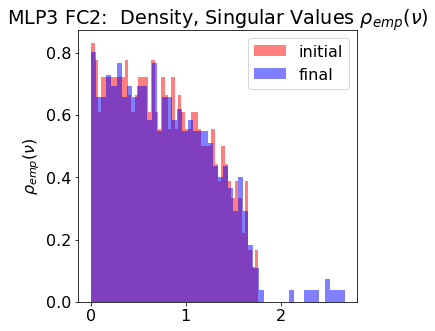

In [24]:
LAYER=LAYER_FC2
EPOCH=0
weightfile = BASELINE_per_epoch_weightfile.format(EPOCH)
eigenvalues0 = RMT_Util.get_eigenvalues(model, weightfile, layer=LAYER)
singular_values0 = np.sqrt(eigenvalues0)

weightfile = BASELINE_final_weightfile
eigenvalues = RMT_Util.get_eigenvalues(model, weightfile, layer=LAYER)
singular_values = np.sqrt(eigenvalues)

plt.hist(eigenvalues0,bins=50, density=True, color='red', alpha=0.5, label="initial")
plt.hist(eigenvalues,bins=50, density=True, color='blue', alpha=0.5, label="final")
plt.title(r"MLP3 FC2:  Empirical Spectral Density $\rho_{emp}(\lambda)$")
plt.ylabel(r"$\rho_{emp}(\lambda)$")
plt.legend()
plt.savefig(FINAL_ESD_FC2_FILE)

plt.show()

plt.hist(singular_values0,bins=50, density=True, color='red', alpha=0.5, label="initial")
plt.hist(singular_values,bins=50, density=True, color='blue', alpha=0.5, label="final")
plt.title(r"MLP3 FC2:  Density, Singular Values $\rho_{emp}(\nu)$")
plt.ylabel(r"$\rho_{emp}(\nu)$")
plt.legend()
plt.savefig(FINAL_SEMICIRCLE_FC2_FILE)

## Scree Plots


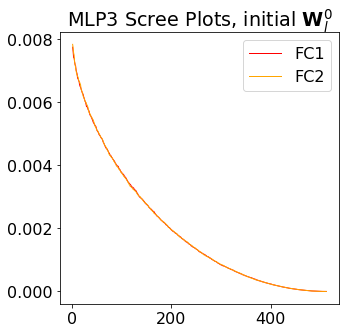

In [25]:
RMT_Util.scree_plot(model, BASELINE_init_weighfile, layer=2, color='red', label="FC1")
RMT_Util.scree_plot(model, BASELINE_init_weighfile, layer=3, color='orange', label="FC2")
plt.title(r"MLP3 Scree Plots, initial $\mathbf{W}_{l}^{0}$")
plt.legend()
plt.savefig(INIT_SCREE_FILE)
plt.show()

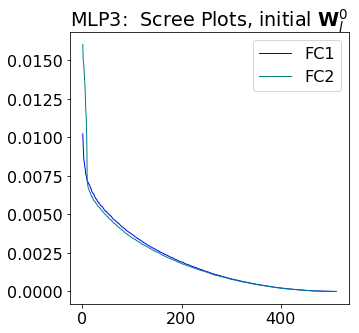

In [26]:
RMT_Util.scree_plot(model, BASELINE_final_weightfile, layer=2, color='blue', label="FC1")
RMT_Util.scree_plot(model, BASELINE_final_weightfile, layer=3, color='teal', label="FC2")
plt.title(r"MLP3:  Scree Plots, initial $\mathbf{W}_{l}^{0}$")
plt.legend()
plt.savefig(FINAL_SCREE_FILE)
plt.show()